Credit for this hack: Meredith Rawls, Geert Barentsen, Brigitta Sipocz (remote).

## Getting set up

1. Install python 2.7 via [Anaconda](https://www.continuum.io/downloads). If you already have a working python 2 installation via Anaconda, just run 
```
conda update conda
```
from the command line instead. (Python 2 is necessary instead of python 3 because the LSST Science Pipelines won't be updated to python 3 until v13.)

2. Follow the directions at the [LSST Science Pipelines](https://pipelines.lsst.io/install/conda.html) website to install the LSST Stack. For v12, these instructions are 
```
conda config --add channels http://conda.lsst.codes/stack
conda create --name lsst python=2
source activate lsst
conda install lsst-distrib
source eups-setups.sh
setup lsst_apps
```
The `install` step will take some time to complete.
Once it is done, you can run three of these commands to be in the correct environment and have the LSST Science Pipeline tools set up:
```
source activate lsst
source eups-setups.sh
setup lsst_apps
```

3. Install `astropy`'s `photutils` package too, when the new "lsst" environment is active
```
conda install -c astropy photutils
```

Now you should be good to go.

## photutils aperture photometry

First, we'll do aperture photometry with photutils, an astropy affiliated package. This example is borrowed from the tutorial-in-progress [here](https://github.com/astropy/astropy-tutorials/pull/99), and updated for photutils v0.3. 

In [7]:
import numpy as np
from photutils import datasets
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture
from astropy.stats import mad_std
from astropy.io import fits
import matplotlib.pylab as plt
%matplotlib inline

In [9]:
#hdu = datasets.load_star_image()
hdu = fits.open('M6707HH.fits')[0]
image = hdu.data[300:800, 300:800]
image = image - np.median(image)
bkg_sigma = mad_std(image)

In [10]:
starfinder = DAOStarFinder(fwhm=4., threshold=3.*bkg_sigma)
sources = starfinder(image)

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=4.)
phot_table = aperture_photometry(image, apertures)
print(phot_table)

 id    xcenter       ycenter      aperture_sum 
         pix           pix                     
--- ------------- -------------- --------------
  1 8.32505593822 0.361671501059  34687.9664115
  2 59.5284509248 0.577005398656   69445.406535
  3 149.486612917  0.49229213635  65453.6846559
  4  99.785726065  3.67338836764 -3016.31423021
  5 114.001684611  6.14804716094  1748.45985935
  6  367.13921519  5.61787322663   171676.20319
  7 492.713278555  5.96981121705  181257.255496
  8 52.5246058408  6.82359774406  -5201.4280847
  9 169.579793605  6.62873717122  38633.8472726
 10  433.66940802  8.01492850099 -7753.31723912
...           ...            ...            ...
753  247.42790774  490.111412927  25370.9222451
754 36.7635046156  490.596411009  118689.250305
755 173.832155611  493.935871101  117403.494267
756  390.53720049  494.918568556  149189.346802
757  214.26806771  496.997708833  11030.9431808
758 24.9610847363   497.91604648  28555.0718082
759  28.878836943  498.101767333  24339.

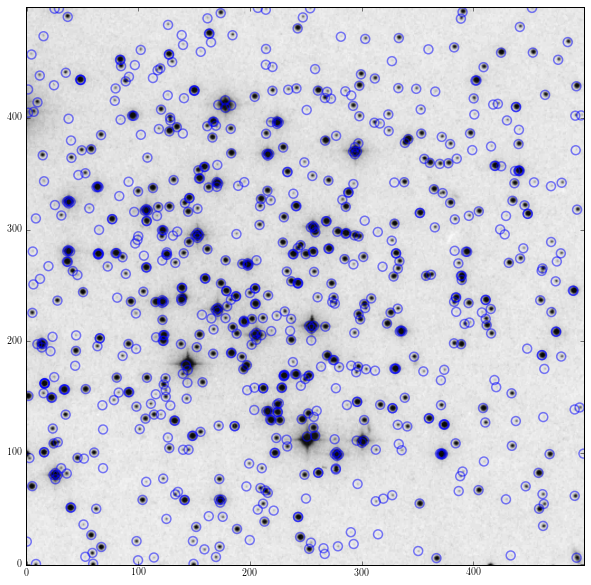

In [11]:
plt.rc('figure', figsize=(10, 10))
plt.imshow(image, cmap='gray_r', origin='lower')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

Hey look it's a bunch of identified sources! The table above shows the summed pixel values within each of the 762 blue circles, along with their coordinates.

## LSST Science Pipelines aperture photometry

Next, let's do the same procedure, but with the LSST processCcd.py routine. Before proceeding, you'll want to save the `M6707HH.fits` file automatically downloaded above in your working directory.

In [12]:
from lsst.pipe.tasks import processCcd

args = ['test', '--filetype', 'raw', '--mode', 'link']
args.extend('M6707HH.fits')